In [1]:
import pandas as pd
import numpy as np
import dill as pickle
from datetime import datetime, timedelta

from cosinorage.datahandlers import NHANESDataHandler, plot_orig_enmo, plot_enmo, plot_orig_enmo_freq
from cosinorage.features import WearableFeatures, plot_sleep_predictions, plot_cosinor

%load_ext autoreload
%autoreload 2

In [2]:
reload_nhanes = True

In [3]:
if reload_nhanes:
    nhanes_loader = NHANESDataHandler(nhanes_file_dir='../data/nhanes/', seqn=62164, verbose=True)
    with open("pickle/nhanes_loader.pkl", "wb") as file:
        pickle.dump(nhanes_loader, file)
else:
    with open("pickle/nhanes_loader.pkl", "rb") as file:
        nhanes_loader = pickle.load(file)

Found 1 versions of NHANES data


Reading day-level files: 100%|██████████| 1/1 [00:00<00:00, 27.13it/s]


Read 9 day-level records for person 62164


Processing chunks for version G: 782it [00:59, 13.23it/s], ?it/s]
Reading minute-level files: 100%|██████████| 1/1 [00:59<00:00, 59.10s/it]


Read 11529 minute-level records for person 62164


Reading header files: 100%|██████████| 1/1 [00:00<00:00, 92.17it/s]


Merged day- and minute-level data for person 62164
Renamed columns and set timestamp index for person 62164
Calculated ENMO for person 62164
Loaded 10080 minute-level ENMO records from ../data/nhanes/
Filtered out 0 minute-level ENMO records due to incomplete daily coverage
Filtered out 0 minute-level ENMO records due to filtering for longest consecutive sequence of days
Resampled 10080 to 10080 timestamps
__load_data executed in 59.39 seconds


/Users/jacobleooskar/Documents/Education/ETHZ/Curriculum/Semester03/03SemProj/CosinorAge/cosinorage/datahandlers/utils/nhanes.py:228: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  _data = _data.resample('1min').interpolate(method='linear').bfill()


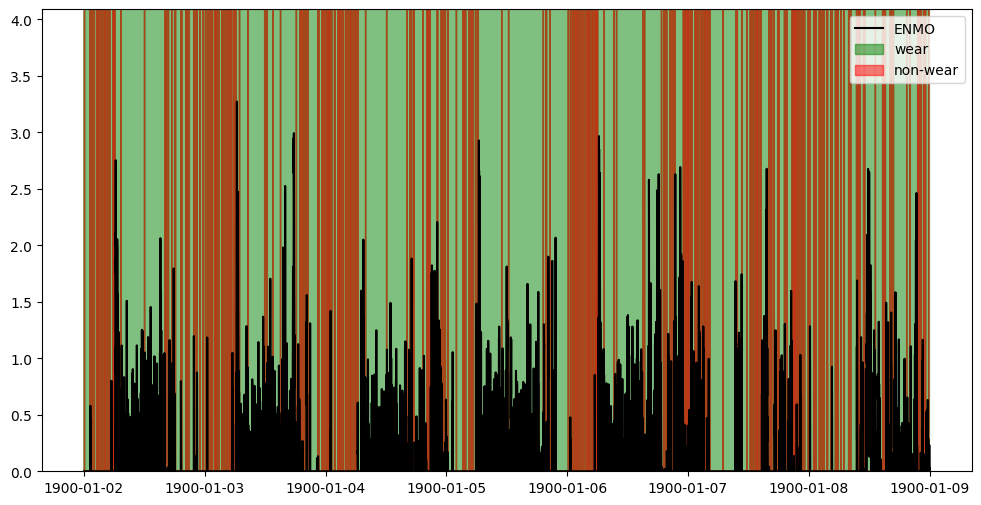

In [4]:
plot_enmo(nhanes_loader)

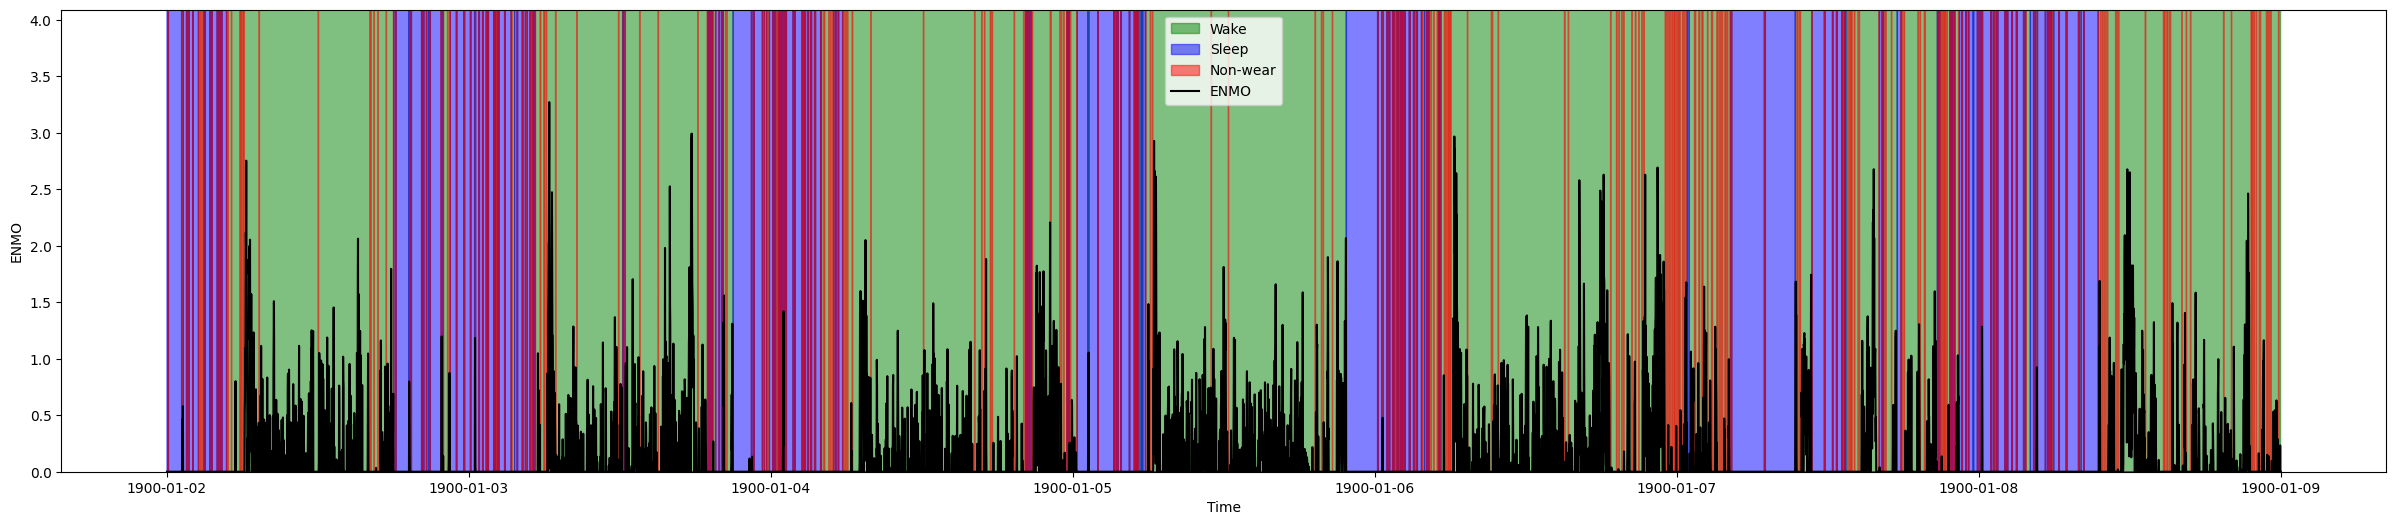

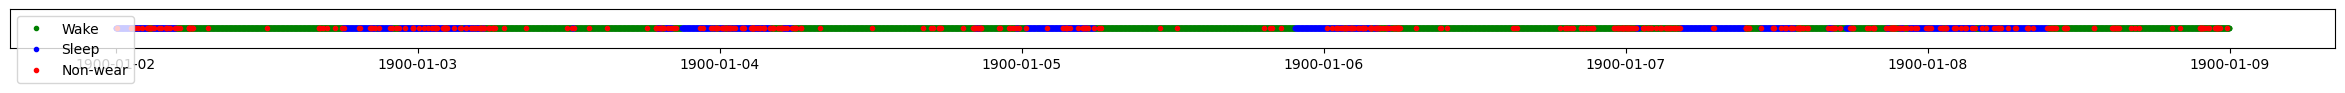

In [5]:
features = WearableFeatures(nhanes_loader)
features.run()
plot_sleep_predictions(features, simple=False)
plot_sleep_predictions(features, simple=True)


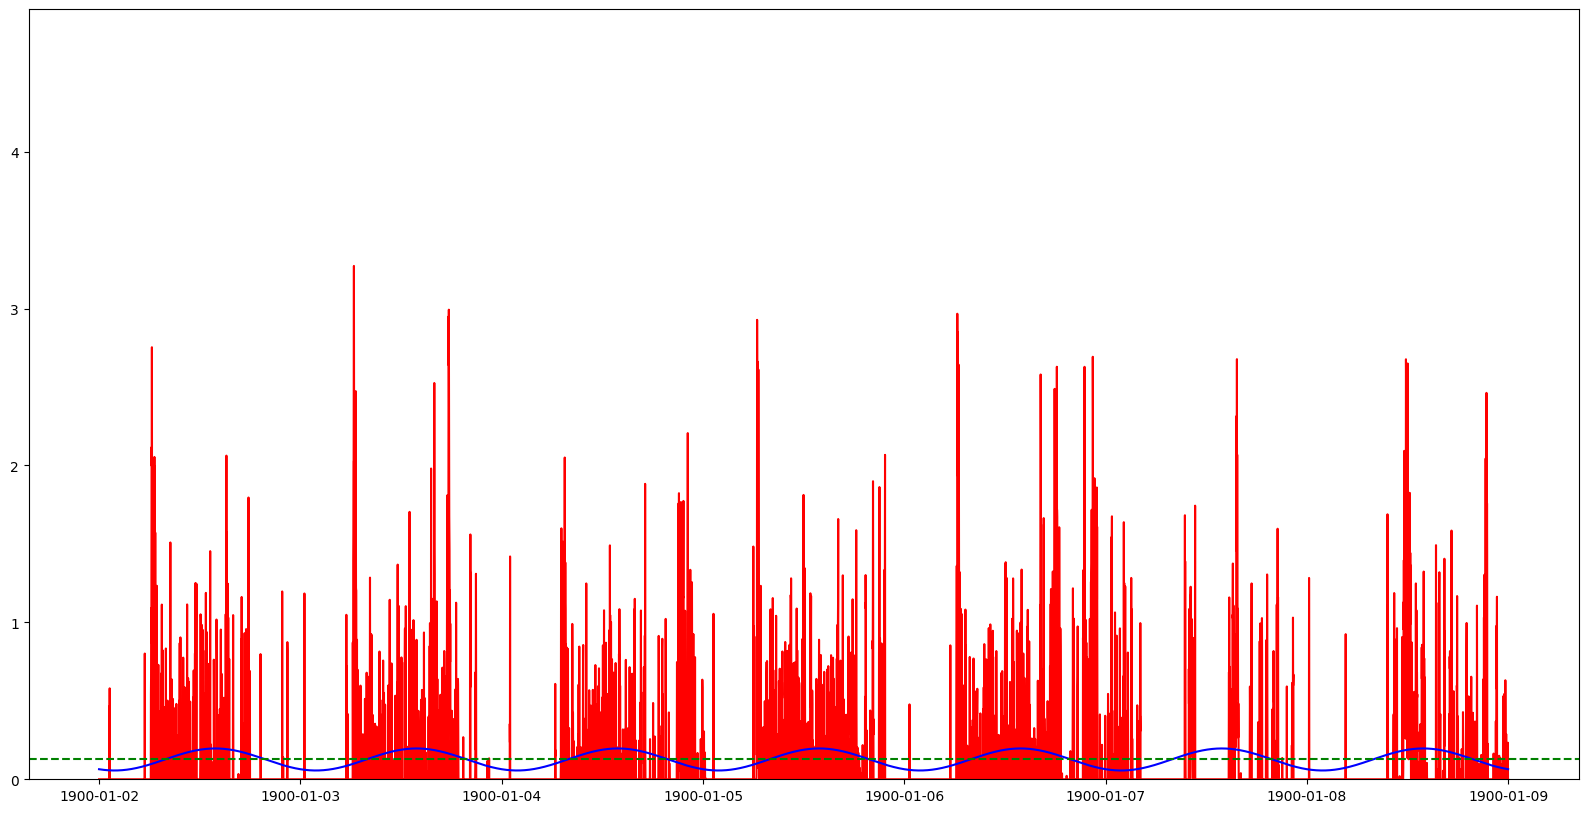

In [6]:
plot_cosinor(features)

In [7]:
features.get_cosinor_features()[1]

{'MESOR': 0.1262241631589706,
 'amplitude': 0.0701964155329349,
 'acrophase': 3.631224591257088,
 'acrophase_time': 13.870256236209906}

In [8]:
nhanes_loader.get_meta_data()

{'datasource': 'nhanes',
 'raw_data_frequency': 0.016666666666666666,
 'raw_data_type': 'accelerometer',
 'raw_data_unit': 'g',
 'n_days': 7}

In [9]:
nhanes_loader.get_raw_data()

,X,Y,Z,wear,sleep,paxpredm,X_raw,Y_raw,Z_raw,ENMO
TIMESTAMP,,,,,,,,,,
1900-01-02 00:00:00,5.502146e-80,5.502146e-80,5.502146e-80,1,1,2,5.397605e-79,5.397605e-79,5.397605e-79,0.000000
1900-01-02 00:01:00,5.502146e-80,5.502146e-80,5.502146e-80,1,1,2,5.397605e-79,5.397605e-79,5.397605e-79,0.000000
1900-01-02 00:02:00,5.502146e-80,5.502146e-80,5.502146e-80,1,1,2,5.397605e-79,5.397605e-79,5.397605e-79,0.000000
1900-01-02 00:03:00,5.502146e-80,5.502146e-80,5.502146e-80,1,1,2,5.397605e-79,5.397605e-79,5.397605e-79,0.000000
1900-01-02 00:04:00,5.502146e-80,5.502146e-80,5.502146e-80,1,1,2,5.397605e-79,5.397605e-79,5.397605e-79,0.000000
...,...,...,...,...,...,...,...,...,...,...
1900-01-08 23:55:00,8.824669e-01,3.152905e-01,4.449541e-01,1,0,1,8.657000e+00,3.093000e+00,4.365000e+00,0.037372
1900-01-08 23:56:00,1.558614e-01,1.524975e-01,1.186544e-01,1,0,1,1.529000e+00,1.496000e+00,1.164000e+00,0.000000
1900-01-08 23:57:00,8.874618e-01,6.111111e-01,5.995923e-01,1,0,1,8.706000e+00,5.995000e+00,5.882000e+00,0.233108


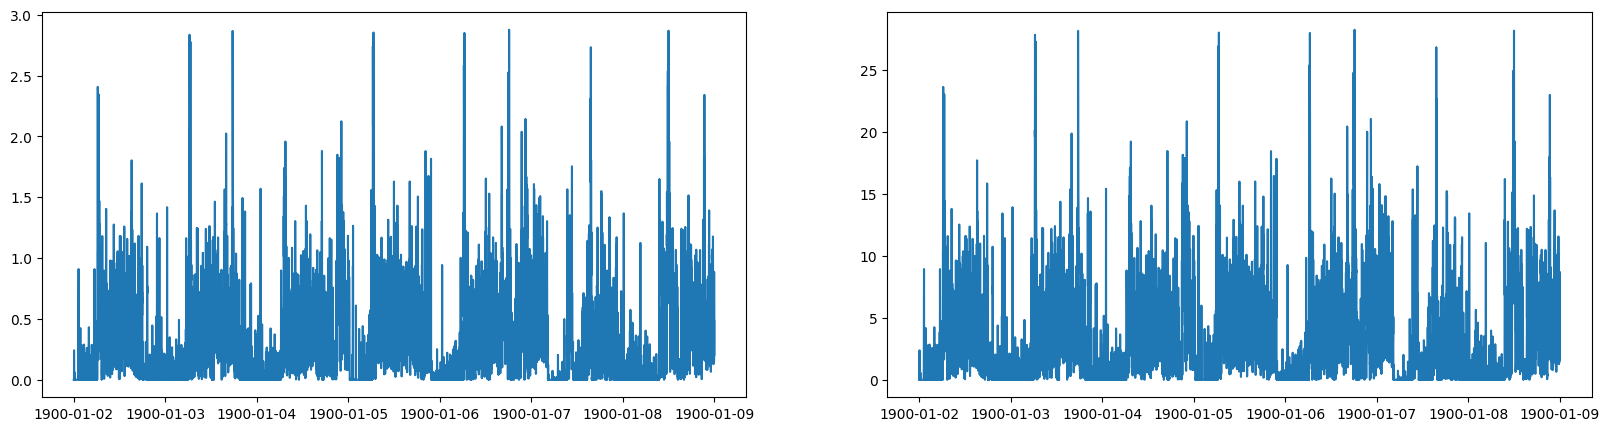

In [10]:
import matplotlib.pyplot as plt
# two plots next to each other
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(nhanes_loader.get_sf_data()['X'])
plt.subplot(1, 2, 2)
plt.plot(nhanes_loader.get_sf_data()['X_raw'])
plt.show()

In [11]:
min(nhanes_loader.get_sf_data()['Y'])


5.502146123276277e-80